# POMDPs for Personalized Mammography Screening 

Alexander Goldberg, Lydia Goldberg, and Gabriela Merz 

## 1. Pre-generated Alpha Vectors

We have pre-generated all of the alpha vectors needed to solve the POMDP for you. If you would like to re-generate these alpha vectors (**warning: takes on the order of hours even with a commercial grade Linear Program Solver**), proceed to section 4. If you would like to use our pre-generated alpha vectors to play around with our results, continue in this section. 

Make sure you have run 

    pip install -r requirements.txt 
    
before attempting to use this notebook.

In [2]:
from monahan import MonahanSolve
from model import CancerPOMDP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import ListedColormap
%matplotlib inline

We have pre-generated the alpha vectors for you for 20, 40, and 80 timesteps, corresponding to a patient living to ages 50, 60, and 80, respectively. Please choose the alpha vectors you would like to use in the cell below, which is defaulted to 80 timesteps.

In [3]:
NUM_VECTORS = 80

Here, we initialize the cancerPOMDP and read in the appropriate alpha vectors. 

In [4]:
cancerPOMDP = MonahanSolve()

In [5]:
cancerPOMDP.readAlpha('alpha/Simple/alpha' + str(NUM_VECTORS) + '.txt')

In [6]:
MAMMOGRAM_DICT = {0: 'WAIT', 1: 'GET A MAMMOGRAM'}

Now, we can experiment with different initial ages and different belief states! We can call "cancerPOMDP.chooseAction(beliefstate, time)" to see whether or not we should get a mammogram based on our initial probabilities.

In [7]:
# list of initial beliefs
# 0th index: probability you're healthy 
# first index: probability you have in-situ cancer 
# second index: probability you have invasive cancer 
# feel free to make these numbers up to test if our results are intuitive 
INITIAL_PROBS = [1, 0, 0]
AGE = 40

In [8]:
print MAMMOGRAM_DICT[cancerPOMDP.chooseAction(INITIAL_PROBS, AGE - 40 * .5)]

WAIT


Good! So if your probability is 1 of being healthy, you opt to wait. Let's delve even futher into the data.

## 2. Examining the Data

We want to be able to see what kind of decisions we make under different conditions, 
i.e. different initial probabilities of cancers and health, and different ages. 
We create the function "genDF" to generate a dataframe of the decisions we make under
different probabilities, which we will then use to plot and visualize our results. Feel free to play around with how we generate the probabilities for the dataframe: right now, we look at discrete increments of .05, because it is easy to visualize on our heatmap below and doesn't take too long to generate. 

In [9]:
def genDF(pomdp): 
    '''
        function genDF
        
        params: pomdp MonohanSolve class 
        
        returns: a dataframe with columns 
        'Age': Age at which each decision was made, incremented by 5 years
            from 40 - max-age
        'Healthy Prior': Prior probability of health 
        'Insitu Prior' : Prior probability of in-situ cancer 
        'Inviasive Prior': Prior probability of invasive cancer
        'Decision' : 0 or 1, 0 to wait, 1 to get a Mammogram
    '''
    time, insitu, invasive, healthy, decisions = [], [], [], [], []
    for t in range(0, NUM_VECTORS + 1, 10): 
        for insitu_prob in range(50): 
            insitu_prob = .05 * insitu_prob
            for invasive_prob in range(50): 
                invasive_prob = .05 * invasive_prob
                if insitu_prob + invasive_prob > 1: 
                    continue 
                else: 
                    healthy_prob = 1 - insitu_prob - invasive_prob 
                    decision = pomdp.chooseAction([healthy_prob, insitu_prob, invasive_prob], t)
                    time.append((t * .5) + 40)
                    insitu.append(insitu_prob)
                    invasive.append(invasive_prob)
                    healthy.append(healthy_prob)
                    decisions.append(decision)
    return pd.DataFrame({'Age': time, 'Healthy Prior': healthy, 'Insitu Prior': insitu, 'Invasive Prior': 
                             invasive, 'Decision': decisions})                    

Now, we generate a table of all the information!

In [10]:
df = genDF(cancerPOMDP)

You can feel free to play with the information like so: 

In [11]:
# look at the first five entries of the dataframe 
df.head()

,Age,Decision,Healthy Prior,Insitu Prior,Invasive Prior
0,40.0,0,1.00,0.0,0.00
1,40.0,1,0.95,0.0,0.05
2,40.0,1,0.90,0.0,0.10
3,40.0,1,0.85,0.0,0.15
4,40.0,1,0.80,0.0,0.20


In [12]:
# look at every probability distribution where we opt to wait instead of
# recieving a mammogram
df[df['Decision'] == 0]

,Age,Decision,Healthy Prior,Insitu Prior,Invasive Prior
0,40.0,0,1.00,0.00,0.00
231,45.0,0,1.00,0.00,0.00
462,50.0,0,1.00,0.00,0.00
693,55.0,0,1.00,0.00,0.00
924,60.0,0,1.00,0.00,0.00
1155,65.0,0,1.00,0.00,0.00
1386,70.0,0,1.00,0.00,0.00
1407,70.0,0,0.95,0.05,0.00
1617,75.0,0,1.00,0.00,0.00
1618,75.0,0,0.95,0.00,0.05


The dataframe is good and all, but you probably want to see some actual ~visualizations~. 
In that case, we define a function "plotAge" which takes in the dataframe we generated
and an age (from 40 - 75, incremented in 5's), and plots a heatmap. The x axis of the 
heatmap is your prior probability of in-situ cancer, and the y axis of your heatmap 
is your prior probability of invasive cancer. A square is red if you should opt to get
a mammogram for those probabilities, and a square is blue if you should opt to wait
instead of getting a mammogram. Note that we are not looking at probabilities in continuous space, but in discrete intervals of .05.

In [13]:
def plotAge(df, age): 
    '''
        function that plots a heatmap 
        of insitu prior vs. invasive prior
        blue squares indicate you opt to wait, 
        red square indicate you should recieve 
        a mammogram
    '''
    new_df = df[df['Age'] == age]
    new_df = new_df.pivot("Invasive Prior", "Insitu Prior", "Decision")
    ax = sns.heatmap(new_df, cmap=ListedColormap(['blue', 'red']), alpha = .2, cbar = False)
    ax.set_title('Mammogram Decisions for Age %s' % age)
    ax.invert_yaxis()

Let's plot the data for age 40!

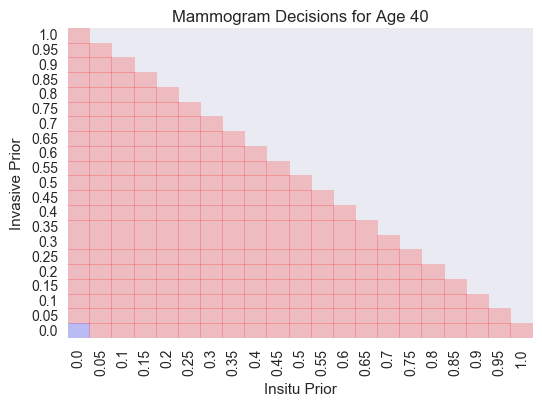

In [14]:
plotAge(df, 40)

So far, this is consistent with the results from the original paper. Let's see what happens when we up the age to 70: 

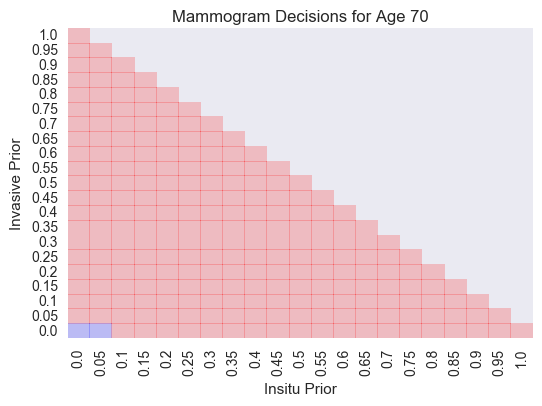

In [15]:
plotAge(df, 70)

And age 75...

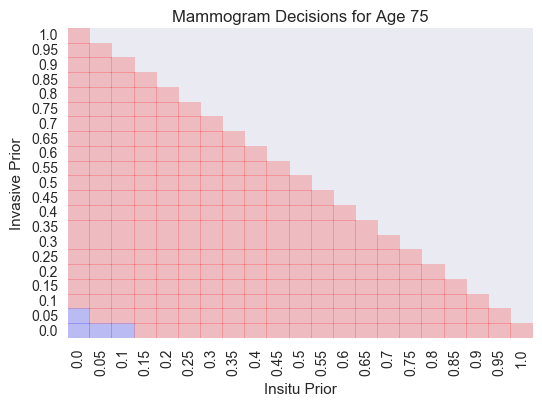

In [16]:
plotAge(df, 75)

Good! This is exactly the behavior we would expect. As we get older, the risk assosciated with a mammogram because less important than the reward (which, as a refresher, is measured in Quality of Life Years or QALYs). So we become more likely to wait instead of opting to recieve a mammogram. 

## 3. How Observations Change the Belief State

Now that we have all this information, we want to verify that our belief state changes appropriately over time as a result of our actions. We'll first need to import some constants that make understanding our code a bit easier, and also write a function that prints our results nicely.

In [17]:
from modelConstants import W, M, MNEG, MPOS, SDNEG, SDPOS

In [18]:
def printBelief(b): 
    beliefs = ['being healthy', 'having in situ cancer', 'having invasive cancer']
    for prob, state in zip(b, beliefs): 
        print "Patient has probability %s of %s" % (prob, state)

We initialize a few belief states to test with: 

In [19]:
# patient is healthy with probability one 
HEALTHY = [1, 0, 0]
# patient is equally likely to be healthy and have in-situ cancer
SPLIT = [.5, .5, 0]

As always, we first perform some sanity checks. If we believe our patient is healthy, and she recieves a negative mammogram, then she should continue to be healthy. Note that the first parameter in updateBeliefState is time, which we set to 0 to represent a woman at age 40.

In [20]:
printBelief(cancerPOMDP.updateBeliefState(0, HEALTHY, MNEG))

Patient has probability 1.0 of being healthy
Patient has probability 0.0 of having in situ cancer
Patient has probability 0.0 of having invasive cancer


Now that that's out of the way, let's look at how a negative  self-detection vs. a negative mammogram changes the underlying belief state when a patient has equal probability of being sick or healthy. 

In [21]:
print "For split probability of healthy and in-situ with a negative mammogram: \n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, MNEG))

For split probability of healthy and in-situ with a negative mammogram: 

Patient has probability 0.746292396594 of being healthy
Patient has probability 0.253707603406 of having in situ cancer
Patient has probability 0.0 of having invasive cancer


In [22]:
print "For split probability of healthy and in-situ with a negative self detection: \n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, SDNEG))

For split probability of healthy and in-situ with a negative self detection: 

Patient has probability 0.833151024575 of being healthy
Patient has probability 0.166848975425 of having in situ cancer
Patient has probability 0.0 of having invasive cancer


This is consistent with our original probabilities, even though it may seem counterintuitive at first, in that the true negative rate for self detection is higher than the true negative for mammograms (See the specificities for mammograms and self detection in stats.py or in Ayer et. al). So if a patient doesn't self detect, she's actually more likely to be healthy than if she has a negative mammogram!

We can also compare the changes in initial belief state for a positive mammogram vs. a positive self-detection, although the results may be even less intuitive at first. This is because if a patient recieves a positive mammogram and is found to have cancer, she immediately exits our model and recieves treatment. As described in Ayer et. al, this has to do with the fact that a patient immediately recieves a biopsy after a positive mammogram, and knows with probability one whether she is healthy or not. This implies that in our model a positive mammogram denotes a *false positive mammogram*, so the patient's probability of being healthy just becomes the population's probability of being healthy, which can be found in stats.py.

In [24]:
print "Belief state of a patient after recieving a false-positive mammogram:\n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, MPOS))

Belief state of a patient after recieving a false-positive mammogram:

Patient has probability 0.993 of being healthy
Patient has probability 0.001 of having in situ cancer
Patient has probability 0.002 of having invasive cancer


In [25]:
print "Belief state of a patient after recieving self-detection:\n"
printBelief(cancerPOMDP.updateBeliefState(0, SPLIT, SDPOS))

Belief state of a patient after recieving self-detection:

Patient has probability 0.255623721881 of being healthy
Patient has probability 0.744376278119 of having in situ cancer
Patient has probability 0.0 of having invasive cancer


Overall, our results are intuitive and consistent! Feel free to experiment with different initial ages and belief states.

## 4. Re-solving the POMDP

If you would like to re-solve the POMDP, and have installed everything in requirements.txt, you should be able to run the following command to solve the POMDP (find the alpha vectors). In our write-up, we describe the various LP solvers we used to optimize. Since CPLEX is a commercial solver and cvxopt requires extra steps for installation, you will want to use pulp here (which is slower, but works). 


This command will generate the alpha vectors, and you will see a series of output including: 

1. which LP solver you're using
2. The total number of alpha vectors at each timestep 
3. The total number of alpha vectors after Eagle's reduction 
4. The total number of alpha vectors after solving the Linear Program
5. Which time step you're on 
6. The amount of time it took for each step to run

If you would like to change the default number of timesteps, whether or not you write to a file, etc., please feel free to look through the code in model.py and monohan.py and modify settings as you prefer.

In [23]:
newPOMDP = MonahanSolve().solve()

Using LP Solver pulp 

Total alpha after enumeration: 2, time: 0.00
Total alpha after Eagle: 1, time: 0.00
Total alpha after LP: 1, time: 0.00
	LP construct time:  0
	LP solve time:  0
Completed time step  119 

Total alpha after enumeration: 2, time: 0.00
Total alpha after Eagle: 2, time: 0.00
Total alpha after LP: 2, time: 0.10
	LP construct time:  0.00588202476501
	LP solve time:  0.0986490249634
Completed time step  118 

Total alpha after enumeration: 6, time: 0.00
Total alpha after Eagle: 5, time: 0.00
Total alpha after LP: 4, time: 0.13
	LP construct time:  0.0116662979126
	LP solve time:  0.118786096573
Completed time step  117 

Total alpha after enumeration: 20, time: 0.00
Total alpha after Eagle: 11, time: 0.00
Total alpha after LP: 8, time: 0.21
	LP construct time:  0.0358028411865
	LP solve time:  0.172294378281
Completed time step  116 

Total alpha after enumeration: 72, time: 0.00
Total alpha after Eagle: 32, time: 0.00
Total alpha after LP: 13, time: 0.88
	LP construct

KeyboardInterrupt: 